# Task 3: Correlation between news and stock movement

●	Tasks:

    ○	Date Alignment: Ensure that both datasets (news and stock prices) are aligned by dates. This might involve normalizing timestamps.

    ○	Sentiment Analysis: Conduct sentiment analysis on news headlines to quantify the tone of each article (positive, negative, neutral).Tools: Use Python libraries like nltk, TextBlob for sentiment analysis.

○	Analysis:

    ■	Calculate Daily Stock Returns: Compute the percentage change in daily closing prices to represent stock movements.

    ■	Correlation Analysis: Use statistical methods to test the correlation between daily news sentiment scores and stock returns.

●	KPIs

    ○	Proactivity to self-learn - sharing references.

    ○	Sentiment Analysis

    ○	Correlation Strength



In [14]:
#Import Important Libraries

import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

In [15]:
# Import Data

news_df = pd.read_csv('../Data/newsData/raw_analyst_ratings.csv')

File_loc ={

"apple":"../Data/yfinance_data/Data/AAPL.csv",
"amazon":"../Data/yfinance_data/Data/AMZN.csv",
"google":"../Data/yfinance_data/Data/GOOG.csv",
"meta":"../Data/yfinance_data/Data/META.csv",
"microsoft":"../Data/yfinance_data/Data/MSFT.csv",
"nvidia":"../Data/yfinance_data/Data/NVDA.csv"
}

stock_df=pd.DataFrame()

for ticker_name , file_location in File_loc.items(): # Using a for Loop to avoid repeating each import process
    temp_df = pd.read_csv(file_location) # assigning a temporary data frame for each ticker's data
    temp_df['Company'] = ticker_name # adding a company column for each empor
    stock_df = pd.concat([stock_df, temp_df], ignore_index=True) # appending to the master df 

## Sub Tasks
### 1. Date Alignment (Normalizing Timestamps)

In [16]:
# Convert the date column to datetime objects, handling the timezone

news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce', utc=True)
news_df['date_only'] = news_df['date'].dt.date

## 2. Sentiment Analysis

Assign a numerical score to every headline. Tools: nltk.sentiment.vader & Text Blob

In [ ]:
# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_1(text):
    # Returns a compound score between -1 (Negative) and +1 (Positive)
    return analyzer.polarity_scores(text)['compound']

def get_sentiment_2(text):
    # Returns a compound score between -1 (Negative) and +1 (Positive)
    return TextBlob(text).sentiment.polarity

# Apply to your news dataframe
news_df['sentiment_score_1'] = news_df['headline'].apply(get_sentiment_1) # Using_NLTK.
news_df['sentiment_score_2'] = news_df['headline'].apply(get_sentiment_2) # Using_TextBlob

# AGGREGATION: Since stocks have multiple news articles per day, 
# you must calculate the average sentiment for that specific stock on that specific day.
daily_sentiment_1 = news_df.groupby(['stock', 'date_only'])['sentiment_score_1'].mean().reset_index() # NLTK
daily_sentiment_2 = news_df.groupby(['stock', 'date_only'])['sentiment_score_2'].mean().reset_index() # TextBlob

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\henokt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 3. Calculate Daily Stock Returns

Convert absolute stock prices into percentage movements to make them comparable with sentiment scores. 

In [18]:
# Ensure the dataframe is sorted by Date for percentage calculation
stock_df.sort_values(['Company', 'Date'], inplace=True)

# Calculate Daily Returns
stock_df['daily_return'] = stock_df.groupby('Company')['Close'].pct_change()

# IMPORTANT: Ensure stock_df has a 'Date' column that matches the news_df format
stock_df['date_only'] = pd.to_datetime(stock_df['Date']).dt.date

## 4. Correlation Analysis

Goal: Merge the two datasets and calculate the correlation.

Critical Step (Mapping): In Task 1 (News), the column is stock (e.g., Ticker symbols like 'A', 'AAPL'). In Task 2 (Stocks), the column is Company (e.g., Names like 'apple', 'amazon').

In [ ]:
# 1. Create a mapping dictionary based on news data

ticker_map = {
    'apple': 'AAPL',
    'amazon': 'AMZN',
    'google': 'GOOG',
    'meta': 'META',
    'microsoft': 'MSFT',
    'nvidia': 'NVDA'
}

# 2. Map the company names in stock_df to tickers so they match news_df

stock_df['Ticker'] = stock_df['Company'].map(ticker_map)

# 3. Merge the datasets
# We merge on 'Ticker' (from stock data) == 'stock' (from news data) AND 'date_only'

merged_data_1 = pd.merge(
    stock_df, 
    daily_sentiment_1, 
    left_on=['Ticker', 'date_only'], 
    right_on=['stock', 'date_only'], 
    how='inner' # Use inner to keep only days where we have BOTH news and stock data
) # NLTK

merged_data_2 = pd.merge(
    stock_df, 
    daily_sentiment_2, 
    left_on=['Ticker', 'date_only'], 
    right_on=['stock', 'date_only'], 
    how='inner' # Use inner to keep only days where we have BOTH news and stock data
) # Text Blob

# 4. Calculate Correlation
correlation_matrix_1 = merged_data_1[['sentiment_score_1', 'daily_return']].corr()
print(correlation_matrix_1) #NLTK

correlation_matrix_2 = merged_data_2[['sentiment_score_2', 'daily_return']].corr()
print(correlation_matrix_2) #Text Blob


                   sentiment_score_1  daily_return
sentiment_score_1           1.000000      0.170882
daily_return                0.170882      1.000000
                   sentiment_score_2  daily_return
sentiment_score_2            1.00000       0.16066
daily_return                 0.16066       1.00000


In [ ]:
# Calculate correlation per company
company_correlations_1 = merged_data_1.groupby('Ticker')[['sentiment_score_1', 'daily_return']].corr().iloc[0::2, -1]
print(company_correlations_1) #NLTK

company_correlations_2 = merged_data_2.groupby('Ticker')[['sentiment_score_2', 'daily_return']].corr().iloc[0::2, -1]
print(company_correlations_2) #Text Blob


Ticker                   
AAPL    sentiment_score_1    1.000000
AMZN    sentiment_score_1   -1.000000
GOOG    sentiment_score_1   -0.234365
NVDA    sentiment_score_1    0.522731
Name: daily_return, dtype: float64
Ticker                   
AAPL    sentiment_score_2   -1.000000
AMZN    sentiment_score_2   -1.000000
GOOG    sentiment_score_2   -0.089444
NVDA    sentiment_score_2    0.175699
Name: daily_return, dtype: float64


## 5. Visualization (KPIs)

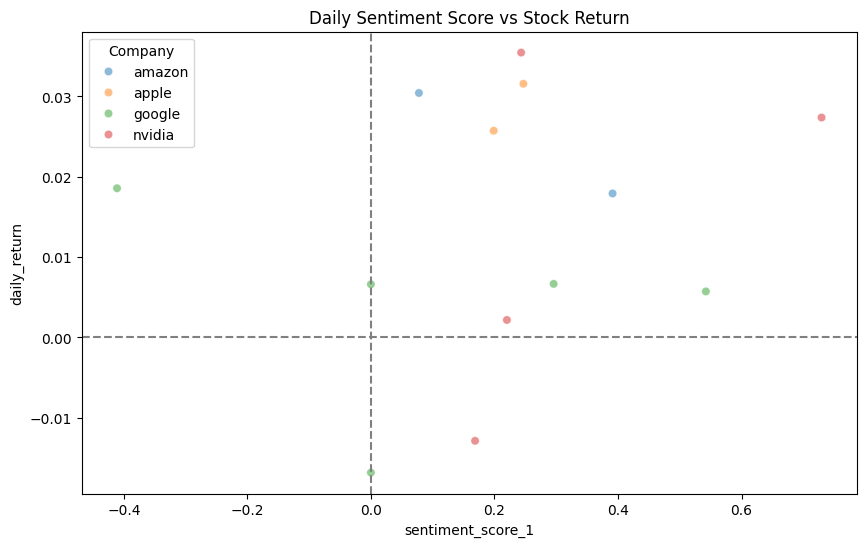

In [24]:
# Using Nltk
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data_1, x='sentiment_score_1', y='daily_return', hue='Company', alpha=0.5)
plt.title("Daily Sentiment Score vs Stock Return")
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.show()

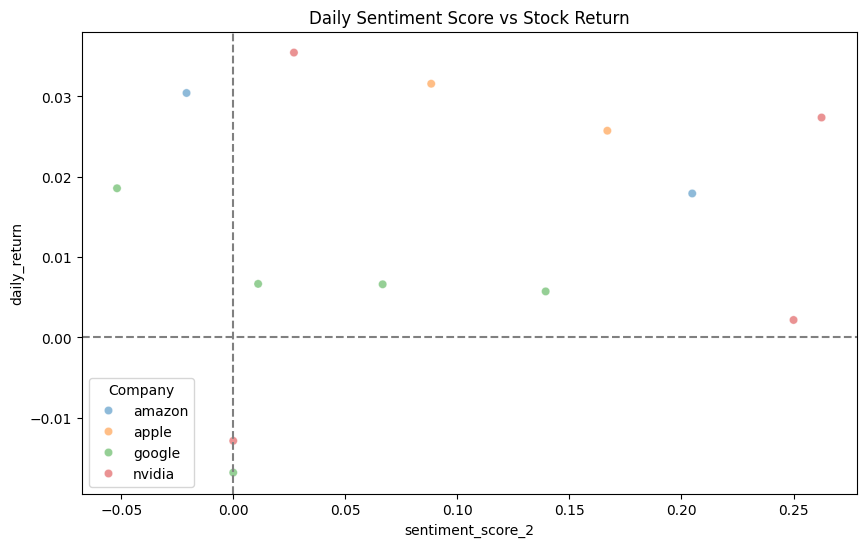

In [25]:
# Using Text Blob
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data_2, x='sentiment_score_2', y='daily_return', hue='Company', alpha=0.5)
plt.title("Daily Sentiment Score vs Stock Return")
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.show()